In [1]:
import collections
from collections import Counter
from pprint import pprint
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from pprint import pprint
from sklearn.model_selection import train_test_split
from IPython.display import JSON
from tqdm import tqdm
import numpy as np
import json
from enum import Enum
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import thundersvm

from coprover import PROJ_ROOT, RSC_ROOT, PVSLIB_ROOT
from featurizer import *

DATA_ROOT = Path(PROJ_ROOT, "data", "pvs", "pvslib")
json_files = list(DATA_ROOT.rglob("*.json"))

theory_files = list(DATA_ROOT.glob("*/*.json"))
proof_files = list(DATA_ROOT.glob("*/*/*.json"))
print(len(theory_files), len(proof_files))

import pdb

class VecTypes:
    COUNT = 1
    TFIDF = 2

class TheoryBank:
    def __init__(self, theory_files, 
                 vectorizer_type=VecTypes.COUNT,
                 norm_vecs=True):
        self.all_theories = collections.OrderedDict()
        self.all_lemmas = collections.OrderedDict()
        for json_fpath in tqdm(theory_files):
            with open(json_fpath, 'r') as f:
                theory_name = json_fpath.stem
                doc_root = json.load(f)
                theory = read_theory(doc_root)
                self.all_theories[theory_name] = theory
                self.all_lemmas.update(theory)
        corpus = [" ".join([str(y) for y in x]) for x in self.all_lemmas.values()]
        self.names = list(self.all_lemmas.keys())
        if vectorizer_type == VecTypes.COUNT:
            self.vectorizer = CountVectorizer(stop_words=None, lowercase=False)
        elif vectorizer_type == VecTypes.TFIDF:
            self.vectorizer = TfidfVectorizer(stop_words=None, lowercase=False)
        self.M = self.vectorizer.fit_transform(corpus).toarray()
        # 1-norm
        self.norm_vecs = norm_vecs
        if self.norm_vecs:
            self.M = self.M / np.linalg.norm(self.M, axis=1).reshape((self.M.shape[0], 1))
        
    def contains(self, name):
        return name in self.names
        
    def query(self, qdocs, top_N=5):
        """
        Expects a list of lists (docs x toks)
        """
        q = self.vectorizer.transform(qdocs).toarray()
        if self.norm_vecs:
            q = q / np.linalg.norm(q, axis=0)
        num_queries = len(qdocs)
        S = self.M.dot(q.transpose())
        sorted_idxes = np.argsort(S, axis=0)
        if top_N is None:
            max_idxes = sorted_idxes
        else:
            max_idxes = sorted_idxes[-top_N:, :]
        
        # Assemble list of names
        titles = []
        for qnum in range(len(qdocs)):
            titles.append([self.names[idx] for idx in max_idxes[::-1, qnum]])
        return titles
    
    def get(self, name, theories=None):
        if theories is None:
            theories = sorted(self.all_theories.keys())
        for theory in theories:
            if name in self.all_theories[theory]:
                return self.all_theories[theory][name], theory
        return None, None
        # raise Exception("Could not identify name={} in theory set={}".format(name, theories))
    
    def sample(self, rand_obj=None):
        if rand_obj is None:
            return np.random.choice(list(self.all_lemmas.values()))
        else:
            return rand_obj.choice(list(self.all_lemmas.values()))
        


615 9216


In [2]:
count_tb_nonorm = TheoryBank(theory_files, vectorizer_type=VecTypes.COUNT, norm_vecs=False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 615/615 [00:02<00:00, 297.44it/s]


In [6]:
all_toks = []
for lemma_content in tqdm(count_tb_nonorm.all_lemmas.values()):
    all_toks.extend(lemma_content)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7235/7235 [00:00<00:00, 300120.55it/s]


<AxesSubplot:>

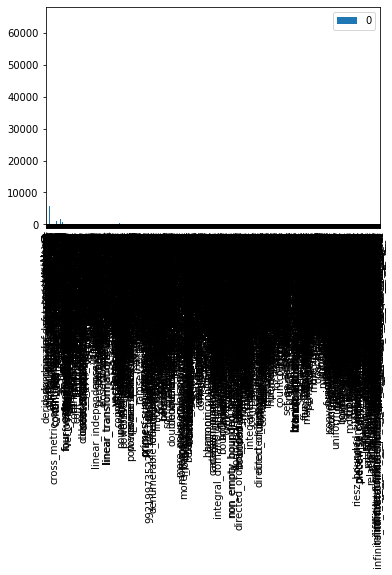

In [12]:
len(all_toks)
tok_count = collections.Counter(all_toks)
tok_df = pd.DataFrame.from_dict(tok_count, orient='index')


<AxesSubplot:title={'center':'Sequent Token by Frequency'}, ylabel='Token'>

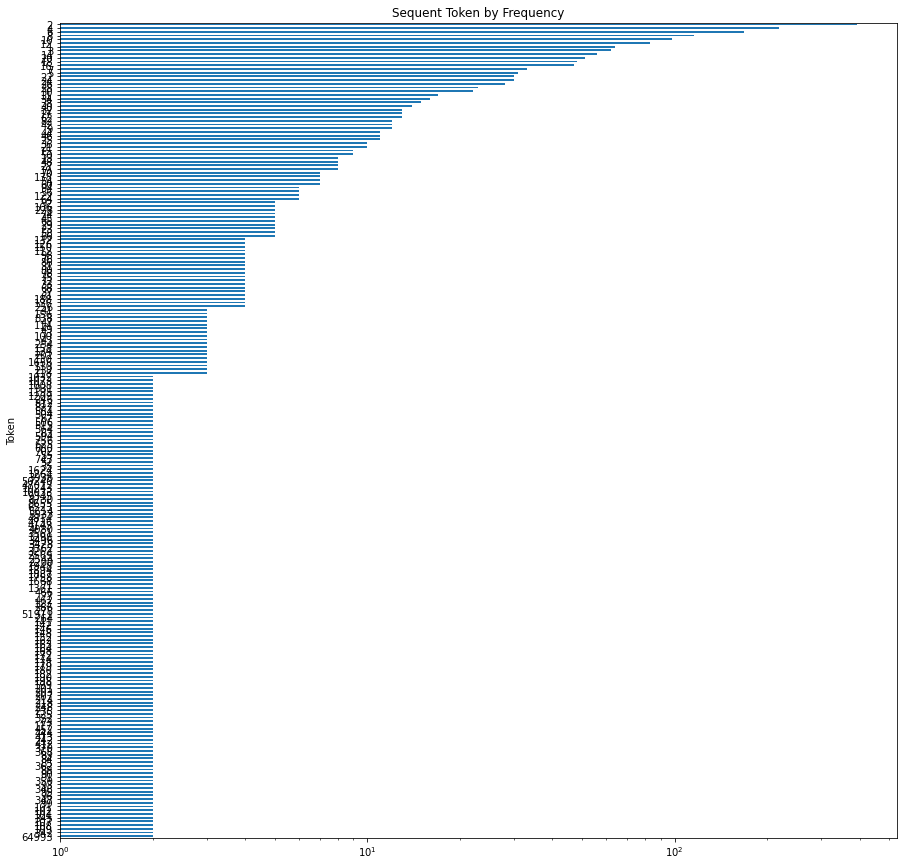

In [25]:
tmp_target = tok_df.groupby(tok_df[0]).size()
tmp_target.sort_values().plot.barh(title="Sequent Token by Frequency", xlabel="Token", ylabel="Frequency", log=True, figsize=(15, 15))

In [23]:
tok_df.columns[0]

0